In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import networkx as nx
import community as community_louvain

In [ ]:
comments = pd.read_csv("data/filtered_comments.csv")

users = pd.read_csv("data/filtered_users.csv")

following = pd.read_csv("data/filtered_following.csv")

likes = pd.read_csv("data/filtered_likes.csv")

entries = pd.read_csv("data/filtered_entries.csv")

-> Graph created successfully.
-> Nodes (Users): 484,251
-> Edges (Connections): 18,477,145
------------------------------
Step 2: Running the Louvain algorithm...
-> Community detection complete.
------------------------------
Step 3: Analyzing community results...
-> Discovered 2282 distinct communities.

Top 10 Largest Social Circles:
 CommunityID  NumberOfMembers
           5           167283
           1            53635
           0            50973
           9            46539
           4            27377
           2            25413
           7            23117
           3            14502
           6            14363
          75            13159
------------------------------
Step 4: Merging and saving results...
-> Successfully saved results to 'results/users_with_communities.csv'
------------------------------
Step 6: Generating Degree Distribution Plot...
-> Degree distribution plot saved to 'results/degree_distribution.png'


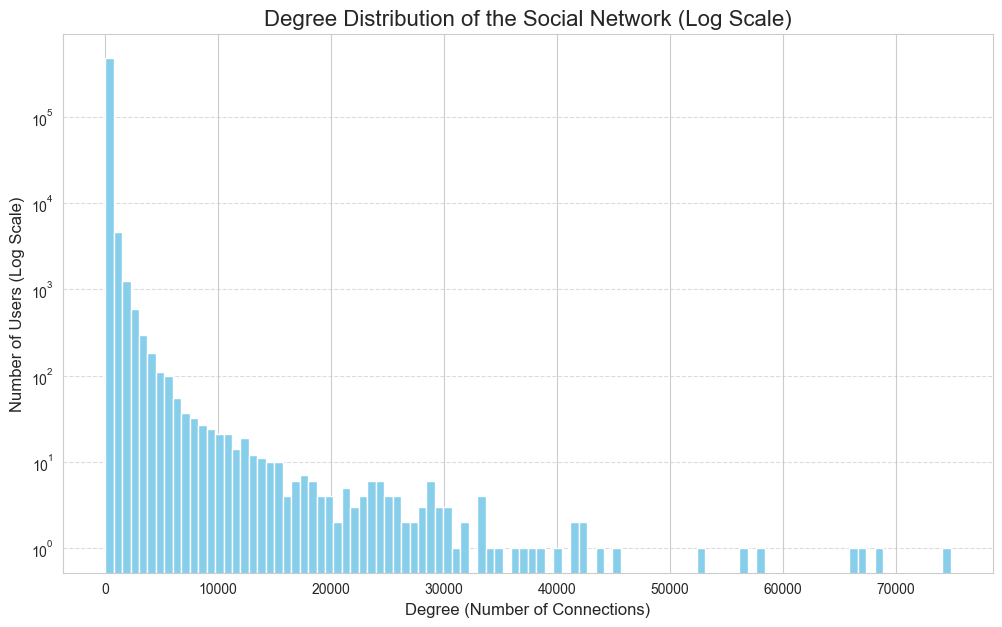

------------------------------


In [ ]:
G = nx.from_pandas_edgelist(following, source='FollowerID', target='FollowedID', create_using=nx.DiGraph())
print(f"Nodes (Users): {G.number_of_nodes():,}")
print(f"Edges (Connections): {G.number_of_edges():,}")

partition = community_louvain.best_partition(G.to_undirected())

num_communities = len(set(partition.values()))
print(f"-> Discovered {num_communities} distinct communities.")

partition_df = pd.DataFrame(list(partition.items()), columns=['ID', 'CommunityID'])
community_sizes = partition_df['CommunityID'].value_counts().reset_index()
community_sizes.columns = ['CommunityID', 'NumberOfMembers']
print("\nTop 10 Largest Social Circles:")
print(community_sizes.head(10).to_string(index=False))

users_with_communities = pd.merge(users, partition_df, on='ID', how='inner')
output_filepath = "results/users_with_communities.csv"
users_with_communities.to_csv(output_filepath, index=False, encoding='utf-8')

degrees = [d for n, d in G.degree()]

plt.figure(figsize=(12, 7))
plt.hist(degrees, bins=100, log=True, color='skyblue', ec='black')
plt.title('Degree Distribution of the Social Network (Log Scale)', fontsize=16)
plt.xlabel('Degree (Number of Connections)', fontsize=12)
plt.ylabel('Number of Users (Log Scale)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

degree_plot_path = 'results/degree_distribution.png'
plt.savefig(degree_plot_path)
plt.show()

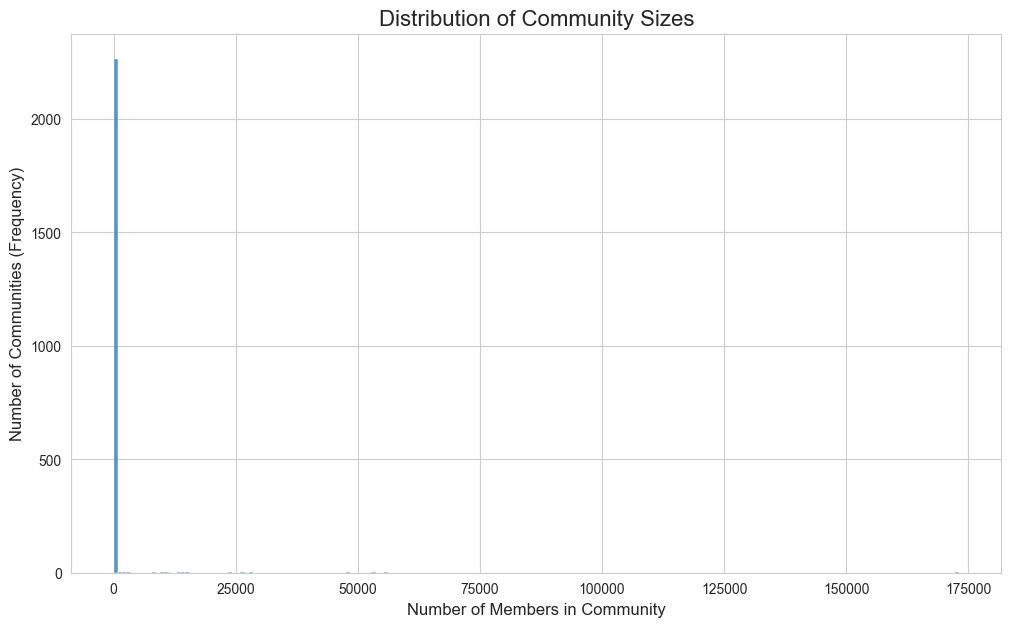


Summary Statistics for Community Sizes:
count      2282.000000
mean        220.039877
std        4246.754404
min           2.000000
25%           2.000000
50%           2.000000
75%           3.000000
max      173077.000000
Name: count, dtype: float64
Average Community Size: 220.04 members
Total Number of Communities: 2282
Number of Small Communities (<100 members): 2258
Number of Singleton Communities (1 member): 0


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

community_sizes = users_with_communities['CommunityID'].value_counts()

sns.set_style("whitegrid")
plt.figure(figsize=(12, 7))

sns.histplot(data=community_sizes, bins=200, kde=False)

plt.title('Distribution of Community Sizes', fontsize=16)
plt.xlabel('Number of Members in Community', fontsize=12)
plt.ylabel('Number of Communities (Frequency)', fontsize=12)

plt.show()

print("\nSummary Statistics for Community Sizes:")
print(community_sizes.describe())

average_size = community_sizes.mean()
print(f"Average Community Size: {average_size:.2f} members")
num_communities = community_sizes.count()
print(f"Total Number of Communities: {num_communities}")

num_small_communities = (community_sizes < 100).sum()
print(f"Number of Small Communities (<100 members): {num_small_communities}")
num_singleton_communities = (community_sizes == 1).sum()
print(f"Number of Singleton Communities (1 member): {num_singleton_communities}")

In [ ]:
import pandas as pd

TOP_N_COMMUNITIES = 10

def print_excel_row(description, data_series):
    if data_series.empty or data_series.isnull().all():
        print(f"{description}\t0.00\t0\t0.00\t0")
        return

    avg = data_series.mean()
    median = data_series.median()
    std_dev = data_series.std()
    std_dev = 0 if pd.isna(std_dev) else std_dev
    max_val = data_series.max()
    print(f"{description}\t{avg:.2f}\t{int(median)}\t{std_dev:.2f}\t{int(max_val)}")

top_communities = users_with_communities['CommunityID'].value_counts().nlargest(TOP_N_COMMUNITIES).index

for community_id in top_communities:
    print(f"\n\nStatistics for Community ID: {community_id}")
   
    print("Type\tAverage\tMedian\tStandard Deviation\tMaximum")

    community_members = users_with_communities[users_with_communities['CommunityID'] == community_id]['ID']

    following_c = following[following['FollowerID'].isin(community_members) | following['FollowedID'].isin(community_members)]
    entries_c = entries[entries['PostedBy'].isin(community_members)]
    likes_c = likes[likes['userID'].isin(community_members)]
    comments_c = comments[comments['PostedBy'].isin(community_members)]

    follower_count = following_c[following_c['FollowedID'].isin(community_members)]['FollowedID'].value_counts()
    print_excel_row("Follower Count per User", follower_count)

    following_count = following_c[following_c['FollowerID'].isin(community_members)]['FollowerID'].value_counts()
    print_excel_row("Following Count per User", following_count)

    posts_created = entries_c['PostedBy'].value_counts()
    print_excel_row("Posts Created per User", posts_created)

    if not entries_c.empty:
        likes_per_post = likes.groupby('PostID').size().rename('LikesCount')
        posts_with_likes = entries_c.merge(likes_per_post, on='PostID', how='left').fillna(0)
        avg_likes_received = posts_with_likes.groupby('PostedBy')['LikesCount'].mean()
        print_excel_row("Likes Received per Post per User", avg_likes_received)
    else:
        print_excel_row("Likes Received per Post per User", pd.Series(dtype='float64'))

    likes_given = likes_c['userID'].value_counts()
    print_excel_row("Likes Given per User", likes_given)

    if not entries_c.empty:
        comments_per_post = comments.groupby('PostID').size().rename('CommentsCount')
        posts_with_comments = entries_c.merge(comments_per_post, on='PostID', how='left').fillna(0)
        avg_comments_received = posts_with_comments.groupby('PostedBy')['CommentsCount'].mean()
        print_excel_row("Comments Received per Post per User", avg_comments_received)
    else:
        print_excel_row("Comments Received per Post per User", pd.Series(dtype='float64'))

    comments_given = comments_c['PostedBy'].value_counts()
    print_excel_row("Comments Given per User", comments_given)



# --- Statistics for Community ID: 5 ---
# Copy the block below and paste it into Excel
Type	Average	Median	Standard Deviation	Maximum
Follower Count per User	100.28	33	460.47	42487
Following Count per User	39.90	4	673.58	73103
Posts Created per User	30.28	8	179.59	22375
Likes Received per Post per User	0.01	0	0.12	16
Likes Given per User	33.61	2	164.80	3948
Comments Received per Post per User	0.06	0	0.32	34
Comments Given per User	23.31	3	130.35	4365


# --- Statistics for Community ID: 1 ---
# Copy the block below and paste it into Excel
Type	Average	Median	Standard Deviation	Maximum
Follower Count per User	59.77	7	560.93	36765
Following Count per User	14.47	4	39.18	2848
Posts Created per User	83.17	10	412.92	16082
Likes Received per Post per User	0.01	0	0.07	1
Likes Given per User	6.24	1	20.00	286
Comments Received per Post per User	0.06	0	0.28	15
Comments Given per User	70.37	5	312.14	8205


# --- Statistics for Community ID: 0 ---
# Copy the block below and paste it into Excel
T